<a href="https://colab.research.google.com/github/bakhshipour/GCNs_for_WDS/blob/main/rgcn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Preprocessing

## Convert to PyG and add node and edge features

In [ ]:
from os import times

import numpy as np
import os
import pickle
import networkx as nx
import pandas as pd
from sklearn.preprocessing import StandardScaler


input_folder = './cs224wdatasets'
input_graphs = []
time_steps = 24
max_time = 25


# Step 1: Load and preprocess all graphs
for filename in os.listdir(input_folder):
    if not filename.endswith('.pkl'):
        continue
    filepath = os.path.join(input_folder, filename)

    with open(filepath, 'rb') as f:
        G, link_data, node_data = pickle.load(f)

    # Function to determine node type based on node name
    def get_node_type(n):
        if n.startswith('R'):
            return "Reservoir"
        elif n.startswith('T'):
            return "Tank"
        elif n.startswith('J'):
            return "Junction"
        else:
            return "Unknown"

    # Collect all node features
    node_features_all = {}
    for feat_key in ['demand', 'head', 'pressure', 'quality']:
        node_features_all[feat_key] = node_data[feat_key]

    #sample random start time, from 0 to max_time - time_steps
    start_time = np.random.randint(0, max_time - time_steps)

    for n in G.nodes():
        node_type_str = get_node_type(n)
        G.nodes[n]['node_type'] = node_type_str  # Set node type
        G.nodes[n].pop('type', None)  # Remove existing 'type' attribute if present

        features_24h = {}
        for feat_key in ['demand', 'head', 'pressure', 'quality']:
            if n in node_features_all[feat_key].columns:
                full_series = node_features_all[feat_key][n]
                arr = full_series.iloc[start_time:start_time + time_steps].to_numpy(dtype=np.float32)
                arr = np.nan_to_num(arr)  # Replace NaN with zero
                features_24h[feat_key] = arr.tolist()
            else:
                features_24h[feat_key] = [0] * time_steps  # Default to zeros if feature missing

        # Extract label for 'quality' at the 25th hour
        label_val = node_features_all['quality'][n].iloc[start_time + time_steps] if n in node_features_all['quality'].columns else 0.0
        label_val = 0.0 if pd.isnull(label_val) else label_val
        G.nodes[n]['label'] = float(label_val)

        # Assign historical features to node attributes
        for feat_key in features_24h:
            G.nodes[n][f"{feat_key}_hist"] = features_24h[feat_key]

    # Collect all link (edge) features
    link_features_all = {}
    for feat_key in ['quality', 'flowrate', 'velocity', 'headloss']:
        link_features_all[feat_key] = link_data[feat_key]

    # Function to determine link type based on link name
    def get_link_type(link_name):
        if link_name.startswith("Pipe"):
            return "Pipe"
        elif link_name.startswith("Pump"):
            return "Pump"
        else:
            return "Unknown"

    for u in G.adj:
        for v in G.adj[u]:
            for edge_name, edge_attrs in G.adj[u][v].items():
                link_type_str = get_link_type(edge_name)
                edge_attrs['edge_type'] = link_type_str  # Set edge type
                edge_attrs.pop('type', None)  # Remove existing 'type' attribute if present

                for feat_key in link_features_all:
                    if edge_name in link_features_all[feat_key].columns:
                        full_series = link_features_all[feat_key][edge_name].iloc[start_time:start_time + time_steps]
                        full_series = np.nan_to_num(full_series)  # Replace NaN with zero
                        edge_attrs[f"{feat_key}_hist"] = full_series.tolist()
                    else:
                        edge_attrs[f"{feat_key}_hist"] = [0] * time_steps  # Default to zeros if feature missing

                # Extract label for 'quality' at the 25th hour
                if edge_name in link_features_all['quality'].columns:
                    q_label = link_features_all['quality'][edge_name].iloc[start_time + time_steps]
                    q_label = 0.0 if pd.isnull(q_label) else q_label
                    edge_attrs['quality_label'] = float(q_label)
                else:
                    edge_attrs['quality_label'] = 0.0

    # Append the processed graph to the list
    input_graphs.append(G)


## Plot two random graphs

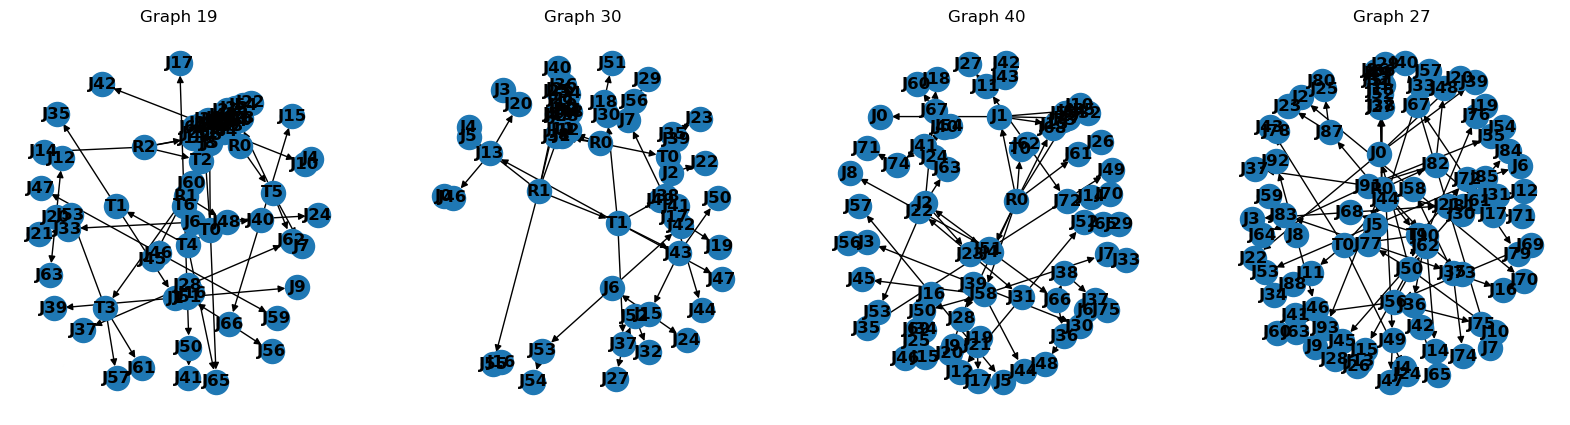

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

# Plot 4 random graphs
axes, fig = plt.subplots(1, 4, figsize=(20, 5))
idx = np.random.choice(len(input_graphs), 4, replace=False)

for i, j in enumerate(idx):
    G = input_graphs[j]
    ax = fig[i]
    ax.set_title(f"Graph {j}")
    pos = nx.spring_layout(G)
    nx.draw(G, pos, ax=ax, with_labels=True, font_weight='bold')

plt.show()


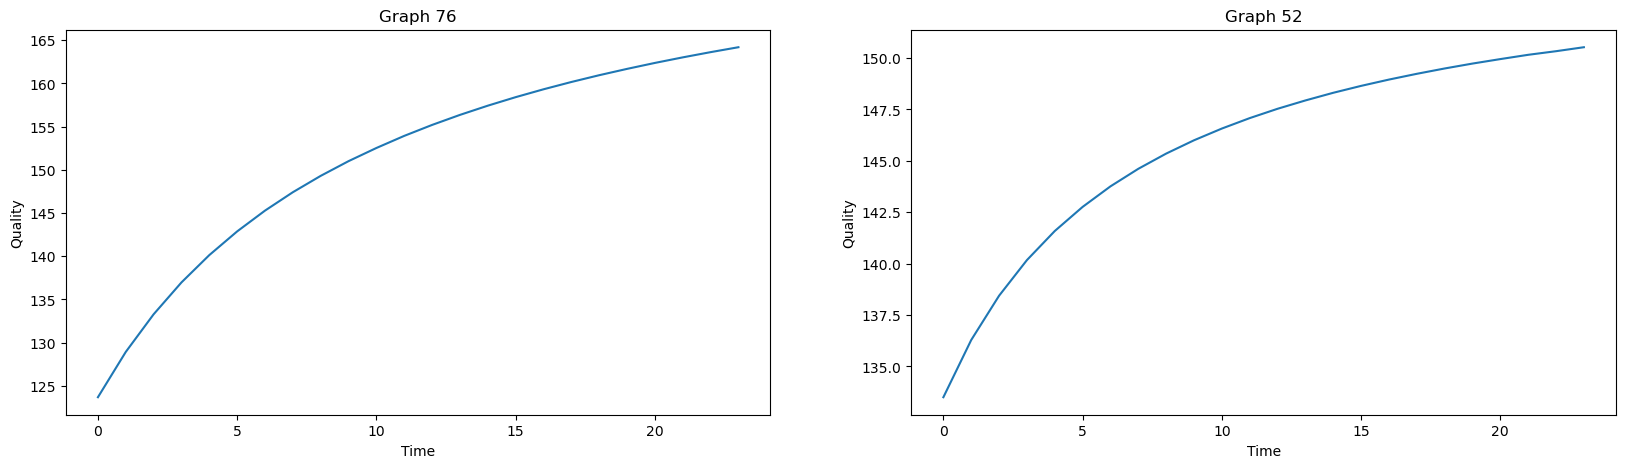

In [ ]:
#plot two random quality time series for one node from each graph
axes, fig = plt.subplots(1, 2, figsize=(20, 5))
idx = np.random.choice(len(input_graphs), 2, replace=False)

for i, j in enumerate(idx):
    G = input_graphs[j]
    ax = fig[i]
    ax.set_title(f"Graph {j}")
    node = np.random.choice(list(G.nodes()))
    node_data = G.nodes[node]
    ax.plot(node_data['quality_hist'])
    ax.set_xlabel('Time')
    ax.set_ylabel('Quality')

plt.show()


## Collect all node and edge features and labels for standardization

In [ ]:

# Define node and edge feature keys
node_feature_keys = ['demand_hist', 'head_hist', 'pressure_hist', 'quality_hist']
node_label_key = 'label'

edge_feature_keys = ['quality_hist', 'flowrate_hist', 'velocity_hist', 'headloss_hist']
edge_label_key = 'quality_label'

# Initialize dictionaries to collect features
node_features_collected = {key: [] for key in node_feature_keys}
node_labels_collected = []

edge_features_collected = {key: [] for key in edge_feature_keys}
edge_labels_collected = []

# Collect node features and labels
for G in input_graphs:
    for n, data in G.nodes(data=True):
        for key in node_feature_keys:
            node_features_collected[key].extend(data[key])
        node_labels_collected.append(data[node_label_key])

# Collect edge features and labels
for G in input_graphs:
    for u, v, data in G.edges(data=True):
        for key in edge_feature_keys:
            edge_features_collected[key].extend(data[key])
        edge_labels_collected.append(data[edge_label_key])



# Initialize scalers for node features
node_feature_scalers = {}
for key in node_feature_keys:
    scaler = StandardScaler()
    feature_array = np.array(node_features_collected[key]).reshape(-1, 1)
    scaler.fit(feature_array)
    node_feature_scalers[key] = scaler

# Initialize scaler for node labels
scaler_label_node = StandardScaler()
labels_node_array = np.array(node_labels_collected).reshape(-1, 1)
scaler_label_node.fit(labels_node_array)

# Initialize scalers for edge features
edge_feature_scalers = {}
for key in edge_feature_keys:
    scaler = StandardScaler()
    feature_array = np.array(edge_features_collected[key]).reshape(-1, 1)
    scaler.fit(feature_array)
    edge_feature_scalers[key] = scaler

# Initialize scaler for edge labels
scaler_label_edge = StandardScaler()
labels_edge_array = np.array(edge_labels_collected).reshape(-1, 1)
scaler_label_edge.fit(labels_edge_array)

#Apply standardization to node features and labels
for G in input_graphs:
    for n, data in G.nodes(data=True):
        for key in node_feature_keys:
            original = np.array(data[key]).reshape(-1, 1)
            standardized = node_feature_scalers[key].transform(original).flatten().tolist()
            G.nodes[n][key] = standardized  # Update node feature with standardized values
        # Standardize node label
        original_label = np.array([data[node_label_key]]).reshape(-1, 1)
        standardized_label = scaler_label_node.transform(original_label)[0][0]
        G.nodes[n][node_label_key] = standardized_label  # Update node label

#Apply standardization to edge features and labels
for G in input_graphs:
    for u, v, key, data in G.edges(data=True, keys=True):
        for feat_key in edge_feature_keys:
            original = np.array(data[feat_key]).reshape(-1, 1)
            standardized = edge_feature_scalers[feat_key].transform(original).flatten().tolist()
            G.edges[u, v, key][feat_key] = standardized
        # Standardize edge label
        original_label = np.array([data[edge_label_key]]).reshape(-1, 1)
        standardized_label = scaler_label_edge.transform(original_label)[0][0]
        G.edges[u, v, key][edge_label_key] = standardized_label


print(f"loaded {len(input_graphs)} graphs")

loaded 466 graphs


In [ ]:
#check relation numbers (different source and target node types)
relation_types = set()
for G in input_graphs:
    for u,v,attrs in G.edges(data=True):
        relation_types.add((G.nodes[u]['node_type'], G.nodes[v]['node_type'], attrs['edge_type']))
print(relation_types)



{('Tank', 'Tank', 'Pipe'), ('Junction', 'Junction', 'Pipe'), ('Reservoir', 'Junction', 'Pipe'), ('Junction', 'Junction', 'Pump'), ('Reservoir', 'Tank', 'Pipe'), ('Tank', 'Junction', 'Pipe')}


# Baseline Models

In [ ]:
########################################################
# Main Training Loop
########################################################
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    for batch in loader:
        batch = batch.to(device)
        #print(batch.edge_index)
        out = model(batch)
        # out: (N,1)
        # batch.y: (N,)
        #print(out.shape)
        out = out.squeeze(-1)
        loss = criterion(out, batch.y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss/len(loader)

def eval_epoch(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            out = model(batch).squeeze(-1)
            loss = criterion(out, batch.y)
            total_loss += loss.item()
    return total_loss/len(loader)


from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
def train(model, model_name, train_loader, val_loader, test_loader, criterion, optimizer, scheduler, device, num_epochs=100, load_saved_file = False,
          eval_test = False):
    """
    Main training loop for the model.
    """
    result_info = {'model_name': model_name}
    best_val_loss = float('inf')
    best_model_state = None
    loss_history = []
    if load_saved_file and os.path.exists(f'{model_name}.pth'):
        model.load_state_dict(torch.load(f'{model_name}.pth'))
    else:
        for epoch in range(1, num_epochs + 1):
            train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
            val_loss = eval_epoch(model, val_loader, criterion, device)
            scheduler.step(val_loss)

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model_state = model.state_dict()

            loss_history.append((train_loss, val_loss))
            print(f"Epoch {epoch}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, LR: {optimizer.param_groups[0]['lr']:.6f}")

    print("Training completed!")
    print(f"Best Validation Loss: {best_val_loss:.4f}")
    result_info['loss_history'] = loss_history

    # Load the best model
    model.load_state_dict(best_model_state)
    torch.save(model.state_dict(), f'{model_name}.pth')

    #eval on val (mse, mae, r2)
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for batch in val_loader:
            batch = batch.to(device)
            out = model(batch).squeeze(-1)
            y_true.extend(batch.y.cpu().numpy())
            y_pred.extend(out.cpu().numpy())
    val_mse = mean_squared_error(y_true, y_pred)
    val_mae = mean_absolute_error(y_true, y_pred)
    val_r2 = r2_score(y_true, y_pred)
    print(f"Val MSE: {val_mse:.4f}, Val MAE: {val_mae:.4f}, Val R²: {val_r2:.4f}")
    result_info['val'] = [val_mse, val_mae, val_r2]

    if eval_test:
        with torch.no_grad():
            y_true = []
            y_pred = []

            for batch in test_loader:
                batch = batch.to(device)
                out = model(batch).squeeze(-1)
                y_true.extend(batch.y.cpu().numpy())
                y_pred.extend(out.cpu().numpy())

        test_mse = mean_squared_error(y_true, y_pred)
        test_mae = mean_absolute_error(y_true, y_pred)
        test_r2 = r2_score(y_true, y_pred)
        print(f"Test MSE: {test_mse:.4f}, Test MAE: {test_mae:.4f}, Test R2: {test_r2:.4f}")
        result_info['test'] = [test_mse, test_mae, test_r2]

    return model, result_info


In [ ]:
#{model_name: str, val: [mse: float, mae: float, r2: float], test: [mse: float, mae: float, r2: float], loss_history: [(train_loss: float, val_loss: float)]}
eval_stats = []

## Simple GCN

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch_geometric.data import Data, HeteroData, Batch
from torch_geometric.nn import GCNConv

import random
import numpy as np
import math
import os
import pickle
import networkx as nx
import pandas as pd

from torch_geometric.loader import DataLoader
from sklearn.metrics import r2_score, mean_squared_error

########################################################
# Data Conversion Function for Baseline GCN
########################################################

def convert_to_pyg_data_baseline(G):
    import torch
    from torch_geometric.data import Data

    node_hist_keys = ['demand_hist','head_hist','pressure_hist','quality_hist']


    nodes = list(G.nodes())
    node_index_map = {n:i for i,n in enumerate(nodes)}


    node_feats = []
    labels = []
    for n in nodes:
        feats = []
        for ft in node_hist_keys:
            feats.append(torch.tensor(G.nodes[n][ft], dtype=torch.float32)) # shape (24,)
        feats = torch.cat(feats, dim=0) # (96,)
        node_feats.append(feats)
        labels.append(G.nodes[n]['label'])
    x_node = torch.stack(node_feats, dim=0) # (N,96)
    labels = torch.tensor(labels, dtype=torch.float32) # (N,)


    edges = list(G.edges())
    src_list = []
    dst_list = []

    for (u, v) in edges:
        src_list.append(node_index_map[u])
        dst_list.append(node_index_map[v])

    if edges:
        edge_index = torch.tensor([src_list, dst_list], dtype=torch.long)
    else:
        edge_index = torch.empty((2,0), dtype=torch.long)

    data = Data(x=x_node, edge_index=edge_index, y=labels)
    return data

########################################################
# Simple GCN Model
########################################################

class SimpleGCN(nn.Module):
    def __init__(self, input_dim=96, hidden_dim1=128, hidden_dim2=64, out_dim=1):
        super(SimpleGCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim1)
        self.conv2 = GCNConv(hidden_dim1, hidden_dim2)
        self.linear = nn.Linear(hidden_dim2, out_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim1)
        self.bn2 = nn.BatchNorm1d(hidden_dim2)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index  # x: [N, 96], edge_index: [2, E]


        x = self.conv1(x, edge_index)  # [N, 128]
        x = self.bn1(x)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)


        x = self.conv2(x, edge_index)  # [N, 64]
        x = self.bn2(x)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)


        out = self.linear(x)  # [N, 1]
        return out.squeeze(-1)  # [N]

########################################################
# Data Loading and Preprocessing
########################################################

all_data = [convert_to_pyg_data_baseline(G) for G in input_graphs]


num_graphs = len(all_data)
indices = list(range(num_graphs))
random.shuffle(indices)
train_split = int(num_graphs * 0.7)
val_split = int(num_graphs * 0.85)

train_idx = indices[:train_split]
val_idx = indices[train_split:val_split]
test_idx = indices[val_split:]

train_data_list = [all_data[i] for i in train_idx]
val_data_list = [all_data[i] for i in val_idx]
test_data_list = [all_data[i] for i in test_idx]


train_loader = DataLoader(train_data_list, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data_list, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data_list, batch_size=32, shuffle=False)




device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_baseline = SimpleGCN(input_dim=time_steps * 4, hidden_dim1=64, hidden_dim2=64, out_dim=1).to(device)


optimizer = optim.AdamW(model_baseline.parameters(), lr=0.001)
criterion = nn.MSELoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                               factor=0.5, patience=5,
                                               min_lr=1e-6)


model_baseline, result_info_baseline = train(model_baseline, 'model_baseline', train_loader, val_loader, test_loader, criterion, optimizer, scheduler, device, num_epochs=100, load_saved_file=False, eval_test=True)




Epoch 1, Train Loss: 0.8235, Val Loss: 0.5890, LR: 0.001000
Epoch 2, Train Loss: 0.5876, Val Loss: 0.4401, LR: 0.001000
Epoch 3, Train Loss: 0.4951, Val Loss: 0.3958, LR: 0.001000
Epoch 4, Train Loss: 0.5108, Val Loss: 0.3964, LR: 0.001000
Epoch 5, Train Loss: 0.4637, Val Loss: 0.4036, LR: 0.001000
Epoch 6, Train Loss: 0.4285, Val Loss: 0.3757, LR: 0.001000
Epoch 7, Train Loss: 0.5598, Val Loss: 0.3896, LR: 0.001000
Epoch 8, Train Loss: 0.5331, Val Loss: 0.3598, LR: 0.001000
Epoch 9, Train Loss: 0.4344, Val Loss: 0.3444, LR: 0.001000
Epoch 10, Train Loss: 0.4433, Val Loss: 0.3834, LR: 0.001000
Epoch 11, Train Loss: 0.4015, Val Loss: 0.3480, LR: 0.001000
Epoch 12, Train Loss: 0.4125, Val Loss: 0.3512, LR: 0.001000
Epoch 13, Train Loss: 0.3653, Val Loss: 0.3511, LR: 0.001000
Epoch 14, Train Loss: 0.3575, Val Loss: 0.3416, LR: 0.001000
Epoch 15, Train Loss: 0.3744, Val Loss: 0.3429, LR: 0.001000
Epoch 16, Train Loss: 0.3950, Val Loss: 0.3344, LR: 0.001000
Epoch 17, Train Loss: 0.3741, Val

In [ ]:
eval_stats = []
eval_stats.append(result_info_baseline)

## RGCN (Without Edge Features and Transformer)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch_geometric.data import Data, HeteroData, Batch
from torch_geometric.nn import RGCNConv

import random
import numpy as np
import math
import os
import pickle
import networkx as nx
import pandas as pd

from torch_geometric.loader import DataLoader
from sklearn.metrics import r2_score, mean_squared_error

########################################################
# Data Conversion Function for Baseline RGCN
########################################################

def convert_to_pyg_data_baseline(G):
    import torch
    from torch_geometric.data import Data

    node_hist_keys = ['demand_hist', 'head_hist', 'pressure_hist', 'quality_hist']


    nodes = list(G.nodes())
    node_index_map = {n: i for i, n in enumerate(nodes)}


    node_feats = []
    labels = []
    for n in nodes:
        feats = []
        for ft in node_hist_keys:
            feats.append(torch.tensor(G.nodes[n][ft], dtype=torch.float32))  # shape (24,)
        feats = torch.cat(feats, dim=0)  # (96,)
        node_feats.append(feats)
        labels.append(G.nodes[n]['label'])
    x_node = torch.stack(node_feats, dim=0)  # (N, 96)
    labels = torch.tensor(labels, dtype=torch.float32)  # (N,)


    edges = list(G.edges(data=True))
    src_list = []
    dst_list = []
    edge_type_list = []


    type_map = {'Pipe': 0, 'Pump': 1, 'Other': 2}
    default_type = 3

    for (u, v, data) in edges:
        src_list.append(node_index_map[u])
        dst_list.append(node_index_map[v])
        edge_type = data.get('edge_type', 'Other')
        edge_type_list.append(type_map.get(edge_type, default_type))

    if edges:
        edge_index = torch.tensor([src_list, dst_list], dtype=torch.long)  # (2, E)
        edge_type = torch.tensor(edge_type_list, dtype=torch.long)  # (E,)
    else:

        edge_index = torch.empty((2, 0), dtype=torch.long)
        edge_type = torch.empty((0,), dtype=torch.long)

    data = Data(x=x_node, edge_index=edge_index, edge_type=edge_type, y=labels)
    return data

########################################################
# Simple RGCN Model
########################################################

class SimpleRGCN(nn.Module):
    def __init__(self, input_dim=96, hidden_dim1=128, hidden_dim2=64, out_dim=1, num_relations=5):
        super(SimpleRGCN, self).__init__()
        self.conv = RGCNConv(input_dim, hidden_dim1, num_relations)
        self.conv2 = RGCNConv(hidden_dim1, hidden_dim2, num_relations)

        self.bn = nn.BatchNorm1d(hidden_dim1)
        self.bn2 = nn.BatchNorm1d(hidden_dim2)
        self.linear = nn.Linear(hidden_dim2, out_dim)




    def forward(self, data):
        x, edge_index, edge_type = data.x, data.edge_index, data.edge_type  # x: [N, 96], edge_index: [2, E], edge_type: [E]


        x = self.conv(x, edge_index, edge_type)  # [N, 128]
        x = self.bn(x)
        x = F.relu(x)

        x = self.conv2(x, edge_index, edge_type)  # [N, 64]
        x = self.bn2(x)
        x = F.relu(x)


        out = self.linear(x)  # [N, 1]
        return out.squeeze(-1)  # [N]

all_data = [convert_to_pyg_data_baseline(G) for G in input_graphs]


num_graphs = len(all_data)
indices = list(range(num_graphs))
random.shuffle(indices)
train_split = int(num_graphs * 0.7)
val_split = int(num_graphs * 0.85)

train_idx = indices[:train_split]
val_idx = indices[train_split:val_split]
test_idx = indices[val_split:]

train_data_list = [all_data[i] for i in train_idx]
val_data_list = [all_data[i] for i in val_idx]
test_data_list = [all_data[i] for i in test_idx]

from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_data_list, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data_list, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data_list, batch_size=32, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_rgcn_baseline = SimpleRGCN(input_dim=time_steps * 4, hidden_dim1=64, hidden_dim2=64, out_dim=1, num_relations=6).to(device)

optimizer = optim.AdamW(model_rgcn_baseline.parameters(), lr=0.0001)
criterion = nn.MSELoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                               factor=0.5, patience=5,
                                               min_lr=1e-6)

model_rgcn_baseline, result_info_rgcn_baseline = train(model_rgcn_baseline, 'model_rgcn_baseline', train_loader, val_loader, test_loader, criterion, optimizer, scheduler, device, num_epochs=100, load_saved_file=False, eval_test=True)


Epoch 1, Train Loss: 1.4055, Val Loss: 0.9935, LR: 0.000100
Epoch 2, Train Loss: 1.0948, Val Loss: 0.8909, LR: 0.000100
Epoch 3, Train Loss: 0.9670, Val Loss: 0.8027, LR: 0.000100
Epoch 4, Train Loss: 0.8718, Val Loss: 0.7215, LR: 0.000100
Epoch 5, Train Loss: 0.7870, Val Loss: 0.6490, LR: 0.000100
Epoch 6, Train Loss: 0.7179, Val Loss: 0.5825, LR: 0.000100
Epoch 7, Train Loss: 0.6022, Val Loss: 0.5246, LR: 0.000100
Epoch 8, Train Loss: 0.5378, Val Loss: 0.4751, LR: 0.000100
Epoch 9, Train Loss: 0.4607, Val Loss: 0.4413, LR: 0.000100
Epoch 10, Train Loss: 0.5211, Val Loss: 0.4114, LR: 0.000100
Epoch 11, Train Loss: 0.3791, Val Loss: 0.3874, LR: 0.000100
Epoch 12, Train Loss: 0.3364, Val Loss: 0.3685, LR: 0.000100
Epoch 13, Train Loss: 0.3031, Val Loss: 0.3511, LR: 0.000100
Epoch 14, Train Loss: 0.2785, Val Loss: 0.3389, LR: 0.000100
Epoch 15, Train Loss: 0.2790, Val Loss: 0.3224, LR: 0.000100
Epoch 16, Train Loss: 0.3310, Val Loss: 0.3052, LR: 0.000100
Epoch 17, Train Loss: 0.2425, Val

In [ ]:
eval_stats.append(result_info_rgcn_baseline)

# Our Model (RGCN with Edge Features and Transformer)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch_geometric.data import Data, HeteroData, Batch
from torch_geometric.nn import MessagePassing
from torch_geometric.nn import RGCNConv
from torch_geometric.nn import Linear

import random
import numpy as np
import torch
import torch.nn as nn
import math

class PositionalEncoding(nn.Module):
    """Adds positional information to the input embeddings."""
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)  # (max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)  # (max_len, 1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() *
                             (-math.log(10000.0) / d_model))  # (d_model/2,)

        pe[:, 0::2] = torch.sin(position * div_term)  # Even indices
        pe[:, 1::2] = torch.cos(position * div_term)  # Odd indices
        pe = pe.unsqueeze(1)  # (max_len, 1, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return x

import torch
import torch.nn as nn
import math


class TransformerFeatureExtractor(nn.Module):
    """Transformer-based feature extractor for time series data."""
    def __init__(self, input_dim, hidden_dim=128, output_dim=128, num_heads=8,
                 num_layers=3, dropout=0.1, max_seq_length=time_steps):
        super(TransformerFeatureExtractor, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim

        # Linear embedding layer
        self.embedding = nn.Linear(input_dim, hidden_dim)

        # Positional encoding
        self.pos_encoder = PositionalEncoding(d_model=hidden_dim, max_len=max_seq_length)

        # Transformer encoder layers
        encoder_layers = nn.TransformerEncoderLayer(d_model=hidden_dim,
                                                    nhead=num_heads,
                                                    dim_feedforward=hidden_dim * 4,
                                                    dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers,
                                                         num_layers=num_layers)

        # Batch Normalization after Transformer
        self.batch_norm = nn.BatchNorm1d(hidden_dim)

        # Pooling layer (e.g., mean pooling)
        self.pool = nn.AdaptiveAvgPool1d(1)

        # Final linear layer to get desired output dimension
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):

        batch_size, num_features, time_steps = x.size()

        # Reshape to (time_steps, batch_size, num_features)
        x = x.permute(2, 0, 1)  # (time_steps, batch_size, num_features)

        # Apply linear embedding
        x = self.embedding(x)  # (time_steps, batch_size, hidden_dim)

        # Apply positional encoding
        x = self.pos_encoder(x)  # (time_steps, batch_size, hidden_dim)

        # Pass through Transformer encoder
        transformer_out = self.transformer_encoder(x)  # (time_steps, batch_size, hidden_dim)

        # Permute back to (batch_size, hidden_dim, time_steps)
        transformer_out = transformer_out.permute(1, 2, 0)  # (batch_size, hidden_dim, time_steps)

        # Apply pooling over the time dimension
        pooled = self.pool(transformer_out)  # (batch_size, hidden_dim, 1)
        pooled = pooled.squeeze(-1)  # (batch_size, hidden_dim)

        # Apply Batch Normalization
        pooled = self.batch_norm(pooled)  # (batch_size, hidden_dim)

        # Final linear layer
        out = self.fc(pooled)  # (batch_size, output_dim)
        return out



########################################################
# Step 2: RGCN that also uses edge features
########################################################

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import MessagePassing
from torch_scatter import scatter_add

#softmax
from torch_geometric.utils import softmax

class RGCNWithEdgeAttention(MessagePassing):

    def __init__(self, in_channels, out_channels, num_relations, edge_dim, heads=1):
        super(RGCNWithEdgeAttention, self).__init__(aggr='add')  # We'll handle attention manually
        self.num_relations = num_relations
        self.heads = heads
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.edge_dim = edge_dim

        # Relation-specific linear transforms
        self.weight = nn.Parameter(torch.Tensor(num_relations, in_channels, out_channels))

        # Attention parameters
        self.att_src = nn.Parameter(torch.Tensor(num_relations, heads, out_channels))
        self.att_dst = nn.Parameter(torch.Tensor(num_relations, heads, out_channels))
        self.att_edge = nn.Parameter(torch.Tensor(num_relations, heads, edge_dim))

        # Batch Normalization
        self.batch_norm = nn.BatchNorm1d(out_channels * heads)

        # Skip connection (if in_channels != out_channels * heads, use linear layer)
        if in_channels != out_channels * heads:
            self.skip_connection = nn.Linear(in_channels, out_channels * heads)
        else:
            self.skip_connection = nn.Identity()

        self.reset_parameters()

    def reset_parameters(self):
        nn.init.xavier_uniform_(self.weight)
        nn.init.xavier_uniform_(self.att_src)
        nn.init.xavier_uniform_(self.att_dst)
        nn.init.xavier_uniform_(self.att_edge)
        nn.init.constant_(self.batch_norm.weight, 1)
        nn.init.constant_(self.batch_norm.bias, 0)

    def forward(self, x, edge_index, edge_type, edge_feat):

        # Save input for skip connection
        skip = x

        # Message Passing
        out = self.propagate(edge_index, x=x, edge_type=edge_type, edge_feat=edge_feat)  # (N, out_channels * heads)

        # Batch Normalization
        out = self.batch_norm(out)

        # Skip Connection
        skip = self.skip_connection(skip)
        out = out + skip

        return out

    def message(self, x_j, x_i, edge_type, edge_feat, index, ptr, size_i):

        # Apply relation-specific transform
        W = self.weight[edge_type]  # (E, in_channels, out_channels)
        x_j_trans = torch.bmm(x_j.unsqueeze(1), W).squeeze(1)  # (E, out_channels)

        # Compute attention scores
        att_src = self.att_src[edge_type]  # (E, heads, out_channels)
        att_dst = self.att_dst[edge_type]  # (E, heads, out_channels)
        att_edge = self.att_edge[edge_type]  # (E, heads, edge_dim)

        # Compute attention logits
        # (E, heads)
        alpha = ((x_j_trans.unsqueeze(1) * att_src).sum(-1) +
                  (x_i.unsqueeze(1) * att_dst).sum(-1) +
                  (edge_feat.unsqueeze(1) * att_edge).sum(-1) )

        alpha = F.leaky_relu(alpha, negative_slope=0.2)
        alpha = softmax(alpha, index)


        alpha = F.softmax(alpha, dim=1)

        # Multiply attention weights with transformed features
        messages = x_j_trans.unsqueeze(1) * alpha.unsqueeze(-1)  # (E, heads, out_channels)

        return messages.view(-1, self.heads * self.out_channels)  # (E, heads*out_channels)

    def update(self, aggr_out):
        return aggr_out


class RGCNWithTransformer(nn.Module):
    def __init__(self, node_input_dim, edge_input_dim, hidden_dim, out_dim, num_relations,
                 transformer_hidden_dim=128, transformer_output_dim=128,  # Changed to 128
                 transformer_num_heads=8, transformer_num_layers=3, transformer_dropout=0.1,
                 transformer_max_seq_length=24, rgcn_middle_layers=2, dropout=0.1):
        super(RGCNWithTransformer, self).__init__()

        # Transformer for node features
        self.node_transformer = TransformerFeatureExtractor(
            input_dim=node_input_dim,
            hidden_dim=transformer_hidden_dim,
            output_dim=transformer_output_dim,
            num_heads=transformer_num_heads,
            num_layers=transformer_num_layers,
            dropout=transformer_dropout,
            max_seq_length=transformer_max_seq_length
        )

        # Transformer for edge features
        self.edge_transformer = TransformerFeatureExtractor(
            input_dim=edge_input_dim,
            hidden_dim=transformer_hidden_dim,
            output_dim=transformer_output_dim,
            num_heads=transformer_num_heads,
            num_layers=transformer_num_layers,
            dropout=transformer_dropout,
            max_seq_length=transformer_max_seq_length
        )

        # First RGCN layer
        self.conv1 = RGCNWithEdgeAttention(
            in_channels=transformer_output_dim,
            out_channels=hidden_dim,
            num_relations=num_relations,
            edge_dim=transformer_output_dim)


        # Middle RGCN layers
        self.middle_convs = nn.ModuleList([
            RGCNWithEdgeAttention(
                in_channels=hidden_dim,
                out_channels=hidden_dim,
                num_relations=num_relations,
                edge_dim=transformer_output_dim,

            ) for _ in range(rgcn_middle_layers)
        ])

        # Final RGCN layer
        self.conv2 = RGCNWithEdgeAttention(
            in_channels=hidden_dim ,
            out_channels=hidden_dim,
            num_relations=num_relations,
            edge_dim=transformer_output_dim

        )

        # Batch Normalization after RGCN layers
        self.batch_norm = nn.BatchNorm1d(hidden_dim)

        # Linear layer for output
        self.linear = nn.Linear(hidden_dim, out_dim)

    def forward(self, data):
        # Input data
        x_node = data.x_node  # (N, num_node_features, 24)
        x_edge = data.x_edge  # (E, num_edge_features, 24)
        edge_index = data.edge_index  # (2, E)
        edge_type = data.edge_type  # (E)

        # Transformer encoding
        node_emb = self.node_transformer(x_node)  # (N, 128)
        edge_emb = self.edge_transformer(x_edge)  # (E, 128)

        # First RGCN layer
        x = self.conv1(node_emb, edge_index, edge_type, edge_emb)  # (N, hidden_dim * heads)
        x = F.relu(x)
        # Batch Normalization




        # Middle RGCN layers
        for conv in self.middle_convs:
            x = conv(x, edge_index, edge_type, edge_emb)  # (N, hidden_dim * heads)
            x = F.relu(x)


        # Final RGCN layer
        x = self.conv2(x, edge_index, edge_type, edge_emb)  # (N, hidden_dim * heads)
        x = F.relu(x)


        # Batch Normalization
        x = self.batch_norm(x)

        # Linear layer for output
        out = self.linear(x)  # (N, out_dim)
        return out



########################################################
# Step 4: Training code
#######################################################

def convert_to_pyg_data(G):
    import torch
    from torch_geometric.data import Data

    node_types = ['demand_hist','head_hist','pressure_hist','quality_hist']
    edge_types = ['quality_hist','flowrate_hist','velocity_hist','headloss_hist']

    nodes = list(G.nodes())
    node_index_map = {n:i for i,n in enumerate(nodes)}

    # Node features
    node_feats = []
    labels = []
    for n in nodes:
        feats = []
        for ft in node_types:
            feats.append(torch.tensor(G.nodes[n][ft], dtype=torch.float32)) # shape (24,)
        feats = torch.stack(feats, dim=0) # (4,24)
        node_feats.append(feats)
        labels.append(G.nodes[n]['label'])
    x_node = torch.stack(node_feats, dim=0) # (N,4,24)
    labels = torch.tensor(labels, dtype=torch.float32) # (N,)

    # Edges
    edges = list(G.edges(keys=True))
    edge_feats = []
    edge_type_list = []

    type_map = {'Pipe':0, 'Pump':1, 'Unknown':2}
    src_list = []
    dst_list = []

    for (u,v,e_key) in edges:
        attrs = G[u][v][e_key]
        # extract edge features
        ef_list = []
        for ft in edge_types:
            ef_list.append(torch.tensor(attrs[ft], dtype=torch.float32))
        ef_tensor = torch.stack(ef_list, dim=0) # (4,24)
        edge_feats.append(ef_tensor)
        edge_type_list.append(type_map.get(attrs['edge_type'], 2))

        src_list.append(node_index_map[u])
        dst_list.append(node_index_map[v])

    x_edge = torch.stack(edge_feats, dim=0) # (E,4,24)
    edge_type = torch.tensor(edge_type_list, dtype=torch.long)
    edge_index = torch.tensor([src_list, dst_list], dtype=torch.long)

    data = Data(x_node=x_node, x_edge=x_edge, edge_index=edge_index, edge_type=edge_type, y=labels)
    return data


all_data = [convert_to_pyg_data(G) for G in input_graphs]


num_graphs = len(all_data)
indices = list(range(num_graphs))
random.shuffle(indices)
train_split = int(num_graphs*0.7)
val_split = int(num_graphs*0.85)

train_idx = indices[:train_split]
val_idx = indices[train_split:val_split]
test_idx = indices[val_split:]

train_data_list = [all_data[i] for i in train_idx]
val_data_list = [all_data[i] for i in val_idx]
test_data_list = [all_data[i] for i in test_idx]


from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_data_list, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data_list, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data_list, batch_size=32, shuffle=False)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = RGCNWithTransformer(
    node_input_dim=4,  # (demand_hist, head_hist, pressure_hist, quality_hist)
    edge_input_dim=4,  # (quality_hist, flowrate_hist, velocity_hist, headloss_hist)
    hidden_dim=128,
    out_dim=1,
    num_relations=6,
    transformer_hidden_dim=128,
    transformer_output_dim=128,
    transformer_num_heads=2,
    transformer_num_layers=2,
    transformer_dropout=0.1,
    transformer_max_seq_length=time_steps,
    rgcn_middle_layers=1
).to(device)

optimizer = optim.AdamW(model.parameters(), lr=0.001)
criterion = nn.MSELoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, min_lr=0.000001)

model, result_info = train(model, 'model', train_loader, val_loader, test_loader, criterion, optimizer, scheduler, device, num_epochs=100, load_saved_file=False, eval_test=True)


C:\Users\cty28\miniforge3\lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch 1, Train Loss: 0.6409, Val Loss: 0.7978, LR: 0.001000
Epoch 2, Train Loss: 0.1136, Val Loss: 0.2714, LR: 0.001000
Epoch 3, Train Loss: 0.0713, Val Loss: 0.3355, LR: 0.001000
Epoch 4, Train Loss: 0.0743, Val Loss: 0.0502, LR: 0.001000
Epoch 5, Train Loss: 0.0620, Val Loss: 0.0331, LR: 0.001000
Epoch 6, Train Loss: 0.0460, Val Loss: 0.0566, LR: 0.001000
Epoch 7, Train Loss: 0.0439, Val Loss: 0.0581, LR: 0.001000
Epoch 8, Train Loss: 0.0402, Val Loss: 0.1143, LR: 0.001000
Epoch 9, Train Loss: 0.0306, Val Loss: 0.0258, LR: 0.001000
Epoch 10, Train Loss: 0.0571, Val Loss: 0.0632, LR: 0.001000
Epoch 11, Train Loss: 0.0750, Val Loss: 0.2321, LR: 0.001000
Epoch 12, Train Loss: 0.0632, Val Loss: 0.0452, LR: 0.001000
Epoch 13, Train Loss: 0.0411, Val Loss: 0.0316, LR: 0.001000
Epoch 14, Train Loss: 0.0412, Val Loss: 0.0346, LR: 0.001000
Epoch 15, Train Loss: 0.0930, Val Loss: 0.0223, LR: 0.001000
Epoch 16, Train Loss: 0.0438, Val Loss: 0.0208, LR: 0.001000
Epoch 17, Train Loss: 0.0298, Val

In [ ]:
eval_stats.append(result_info)

In [ ]:
eval_stats

[{'model_name': 'model_baseline',
  'loss_history': [(0.8234951279380105, 0.5890076458454132),
   (0.5876416672359813, 0.4400710066159566),
   (0.4951405796137723, 0.3957728644212087),
   (0.5108289258046583, 0.3963991701602936),
   (0.46367849003184924, 0.4036213954289754),
   (0.4284947081045671, 0.37567217151323956),
   (0.5597861680117521, 0.3896245261033376),
   (0.5330821140245958, 0.3597800632317861),
   (0.43438857793807983, 0.34437177578608197),
   (0.4433258284221996, 0.3833606739838918),
   (0.40149572220715607, 0.34797892967859906),
   (0.4124927385286851, 0.3512333333492279),
   (0.3653147220611572, 0.35113757848739624),
   (0.35749516026540235, 0.3415812651316325),
   (0.374362975358963, 0.3429187039534251),
   (0.3950335925275629, 0.33440935611724854),
   (0.37408775226636365, 0.346953143676122),
   (0.3530366651036523, 0.33070677518844604),
   (0.3739139315756885, 0.3288225134213765),
   (0.3985850363969803, 0.34077852964401245),
   (0.3748373741453344, 0.33196864525477

In [ ]:
#save best model
torch.save(model.state_dict(), 'best_model.pth')

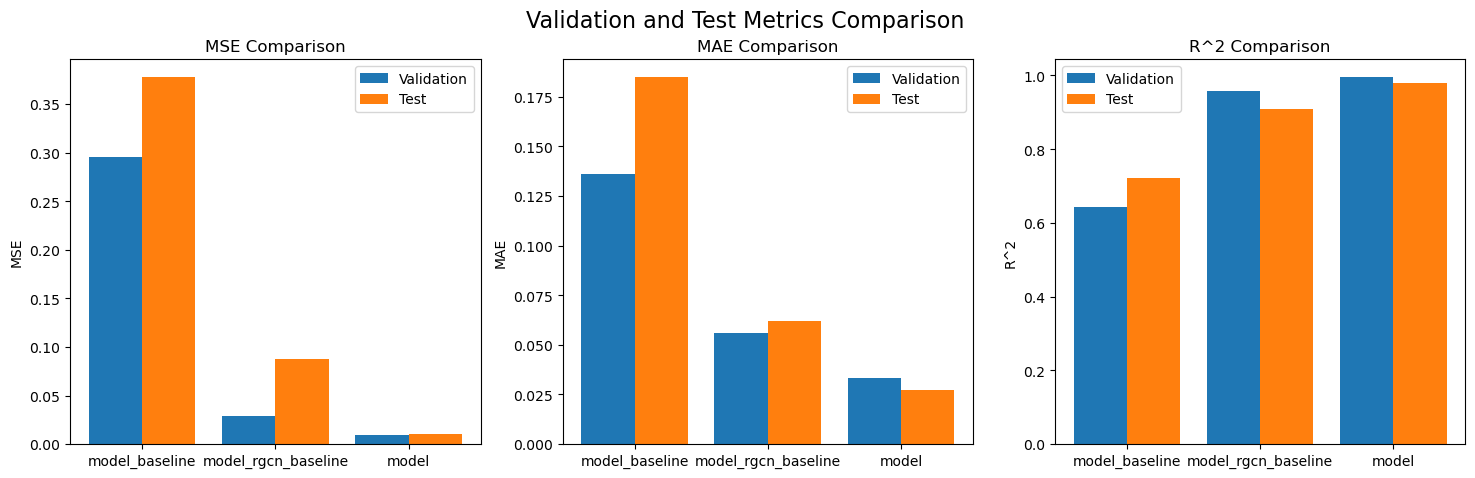

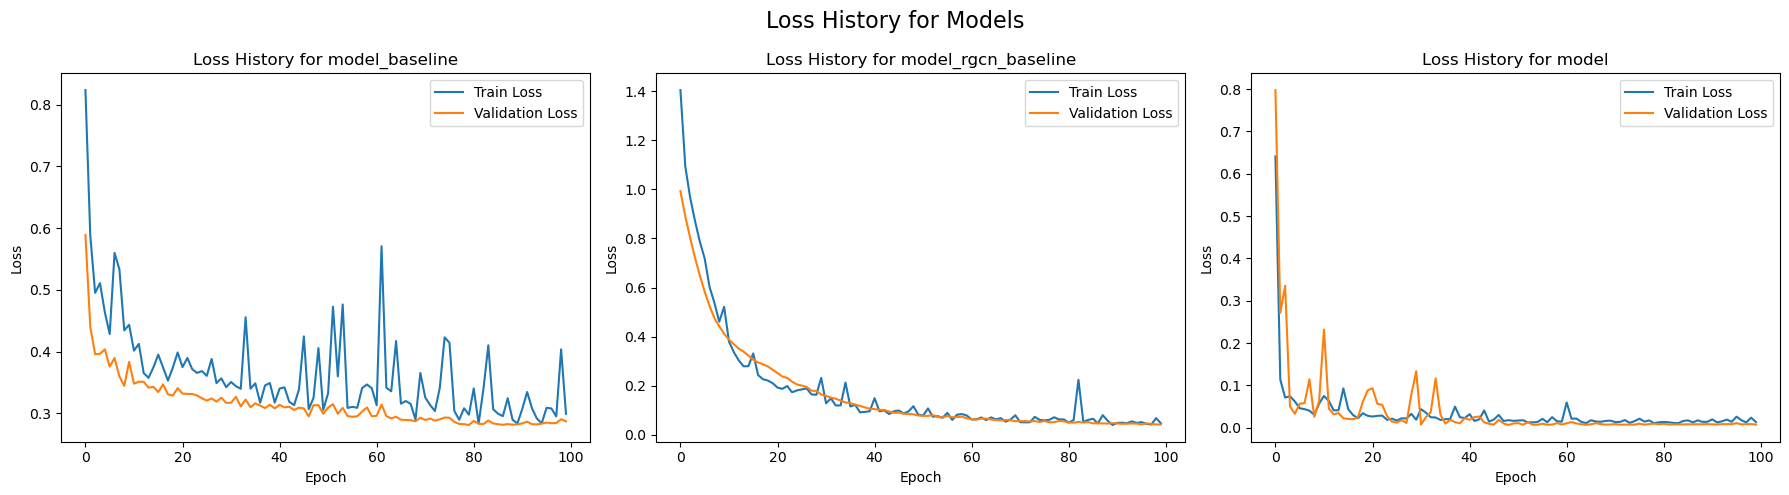

In [ ]:
from matplotlib import pyplot as plt
# Extract and organize data for visualization
models = [stat['model_name'] for stat in eval_stats]
metrics = ['MSE', 'MAE', 'R^2']
val_metrics = np.array([stat['val'] for stat in eval_stats])
test_metrics = np.array([stat['test'] for stat in eval_stats])

fig1, axes1 = plt.subplots(1, 3, figsize=(18, 5))
fig2, axes2 = plt.subplots(1, len(eval_stats), figsize=(18, 5))

# Validation and Test Metrics Plot
metrics = ['MSE', 'MAE', 'R^2']
for i, metric in enumerate(metrics):
    x = np.arange(len(models))
    axes1[i].bar(x - 0.2, val_metrics[:, i], width=0.4, label='Validation')
    axes1[i].bar(x + 0.2, test_metrics[:, i], width=0.4, label='Test')
    axes1[i].set_xticks(x)
    axes1[i].set_xticklabels(models)
    axes1[i].set_ylabel(metric)
    axes1[i].set_title(f'{metric} Comparison')
    axes1[i].legend()

fig1.suptitle('Validation and Test Metrics Comparison', fontsize=16)
plt.tight_layout()

# Loss History Plot
for i, stat in enumerate(eval_stats):
    model_name = stat['model_name']
    loss_history = np.array(stat['loss_history'])
    train_loss = loss_history[:, 0]
    val_loss = loss_history[:, 1]

    axes2[i].plot(train_loss, label='Train Loss')
    axes2[i].plot(val_loss, label='Validation Loss')
    axes2[i].set_xlabel('Epoch')
    axes2[i].set_ylabel('Loss')
    axes2[i].set_title(f'Loss History for {model_name}')
    axes2[i].legend()

fig2.suptitle('Loss History for Models', fontsize=16)
plt.tight_layout()

plt.show()